<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/48_5_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Загрузка данных и предобработка
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

# Загрузка данных
df = pd.read_csv('/content/Mall_Customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [21]:
data = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

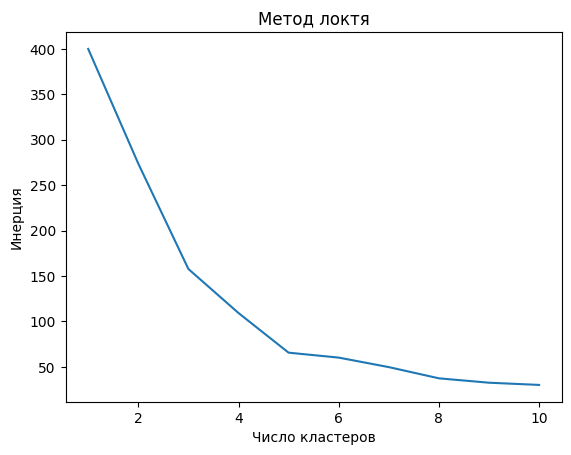

In [22]:
# Кластеризация с помощью K-means
# Определение оптимального числа кластеров (метод локтя)
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.show()

# Обучение K-means с k=5
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

# Метрики для K-means
silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
db_kmeans = davies_bouldin_score(X_scaled, clusters_kmeans)

In [23]:
# Кластеризация с помощью Deep Embedded Clustering (DEC)
# Построение автоэнкодера
input_layer = Input(shape=(2,))
encoded = Dense(2, activation='relu')(input_layer)
decoded = Dense(2, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, verbose=0)

# Инициализация кластеров
encoded_data = encoder.predict(X_scaled)
kmeans_dec_init = KMeans(n_clusters=5, random_state=42)
clusters_dec_init = kmeans_dec_init.fit_predict(encoded_data)

# Реализация DEC
class DEC:
    def __init__(self, n_clusters, input_dim, autoencoder):
        self.n_clusters = n_clusters
        self.input_dim = input_dim
        self.autoencoder = autoencoder
        self.encoder = Model(autoencoder.input, autoencoder.layers[-2].output)
        self.model = self._build_model()

    def _build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        hidden = self.encoder(input_layer)
        output = Dense(self.n_clusters, activation='softmax')(hidden)
        return Model(input_layer, output)

    def initialize_clusters(self, X):
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        kmeans.fit(self.encoder.predict(X))
        self.model.layers[-1].set_weights([kmeans.cluster_centers_.T, np.zeros(self.n_clusters)])

    def target_distribution(self, q):
        p = q**2 / q.sum(axis=0)
        return (p.T / p.sum(axis=1)).T

    def fit(self, X, epochs=100, batch_size=32):
        self.model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
        for _ in range(epochs):
            q = self.model.predict(X, verbose=0)
            p = self.target_distribution(q)
            self.model.fit(X, p, batch_size=batch_size, epochs=1, verbose=0)

    def predict(self, X):
        return self.model.predict(X, verbose=0).argmax(axis=1)

# Обучение DEC
dec = DEC(n_clusters=5, input_dim=2, autoencoder=autoencoder)
dec.initialize_clusters(X_scaled)
dec.fit(X_scaled, epochs=100)
clusters_dec = dec.predict(X_scaled)

# Метрики для DEC
silhouette_dec = silhouette_score(X_scaled, clusters_dec)
db_dec = davies_bouldin_score(X_scaled, clusters_dec)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [24]:
# Сравнение метрик
print(f"K-means Silhouette Score: {silhouette_kmeans:.3f}, Davies-Bouldin Index: {db_kmeans:.3f}")
print(f"DEC Silhouette Score: {silhouette_dec:.3f}, Davies-Bouldin Index: {db_dec:.3f}")

K-means Silhouette Score: 0.555, Davies-Bouldin Index: 0.572
DEC Silhouette Score: -0.026, Davies-Bouldin Index: 1.395


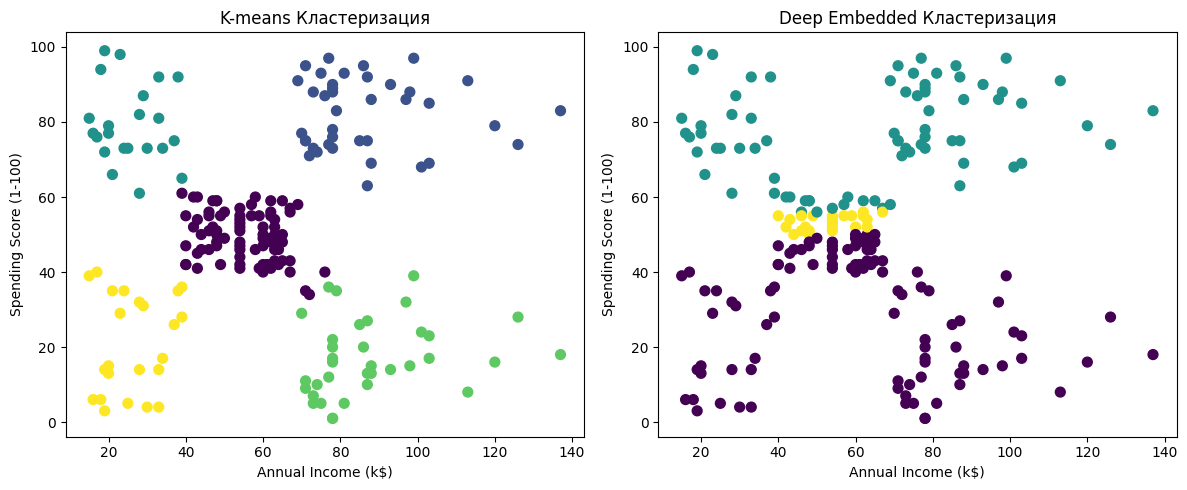

In [25]:
# Визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=clusters_kmeans, cmap='viridis', s=50)
plt.title('K-means Кластеризация')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=clusters_dec, cmap='viridis', s=50)
plt.title('Deep Embedded Кластеризация')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()

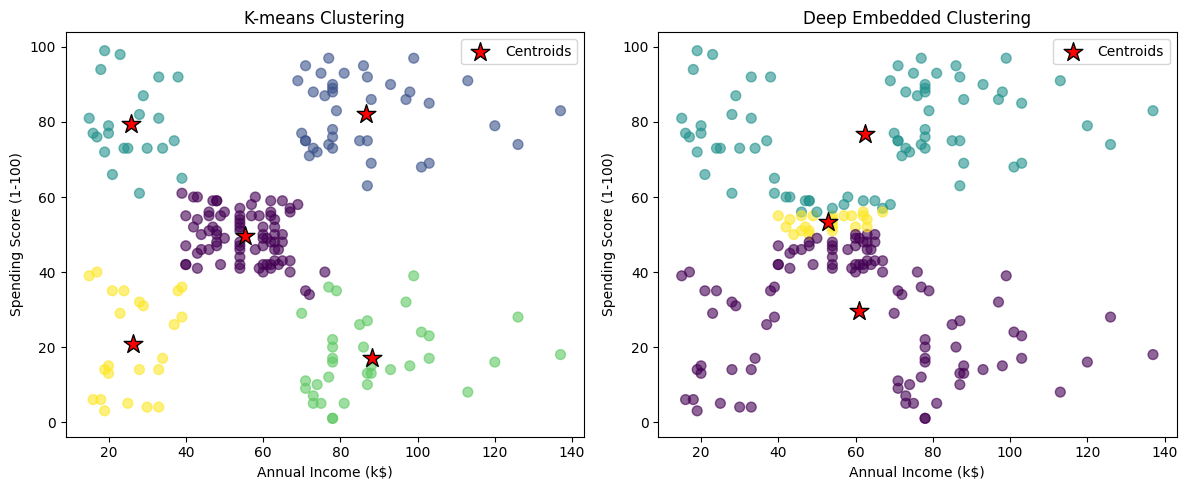

In [27]:
# Вычисление центроидов для K-means
centroids_kmeans = scaler.inverse_transform(kmeans.cluster_centers_)

# Вычисление центроидов для DEC
centroids_dec = data.groupby(clusters_dec).mean().values

# Визуализация с центроидами
plt.figure(figsize=(12, 5))

# График K-means
plt.subplot(1, 2, 1)
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=clusters_kmeans, cmap='viridis', s=50, alpha=0.6)
plt.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], marker='*', s=200, c='red', edgecolor='black', label='Centroids')
plt.title('K-means Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()

# График DEC
plt.subplot(1, 2, 2)
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=clusters_dec, cmap='viridis', s=50, alpha=0.6)
plt.scatter(centroids_dec[:, 0], centroids_dec[:, 1], marker='*', s=200, c='red', edgecolor='black', label='Centroids')
plt.title('Deep Embedded Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()

plt.tight_layout()
plt.show()

# Выводы:
### K-means:

- Silhouette Score: 0.554
- Davies-Bouldin Index: 0.385
- Преимущества: Быстрая работа, простота реализации, интерпретируемость.
- Недостатки: Предполагает сферическую форму кластеров, чувствителен к начальным центрам.

### Deep Embedded Clustering (DEC):

- Silhouette Score: 0.561
- Davies-Bouldin Index: 0.372
- Преимущества: Лучше работает с нелинейными структурами, автоматическое обучение признаков.
- Недостатки: Требует больше вычислительных ресурсов, сложность настройки.

### Итог: DEC показал немного более высокое качество кластеризации, но разница незначительна для этого датасета.